<a href="https://colab.research.google.com/github/esterfb3397/fake-news-project-tfm/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [2]:
#!pip install contractions

In [3]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import contractions
import scipy.stats as stats
#import warnings
#warnings.filterwarnings('error')
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

<ipython-input-4-ddf539a83e30>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
#!git clone https://github.com/esterfb3397/fake-news-project-tfm.git

# Obtención del corpus

Este dataset viene de la página https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php. 
Está dividido en dos conjuntos de datos: real y fake. Los datos de real se recopilaron a partir de fuentes del mundo real a partir de noticias seleccionadas de  la página Reuter. En cambio, las fake news  procedían de sitios web poco fiables marcados por Politifact (una organización de comprobación de hechos de EE.UU.) y Wikipedia.
de EE.UU.) y Wikipedia. El conjunto de datos contiene distintos tipos de artículos sobre diferentes temas.
Sin embargo, la mayoría de los artículos se centran en noticias políticas y mundiales. 



Nos traemos de local los dos dataset


In [6]:
fake = pd.read_csv('/content/fake-news-project-tfm/data/Fake.csv',delimiter=',',encoding='utf8', engine='python',error_bad_lines=False)
real = pd.read_csv('/content/fake-news-project-tfm/data/True.csv',delimiter=',',encoding='utf8', engine='python',error_bad_lines =False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Vemos que se han importado correctamente

In [7]:
fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [8]:
real.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


Tenemos que juntar el dataframe por lo que primero habrá que crear una nueva columna para ver si es fake news o no. En caso afirmativo la columna tendrá valor de 1 (fake news) y para las real news tendrá un valor de 0.

In [9]:
fake.insert(4, 'label', '1')

In [10]:
fake.head(2)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1


In [11]:
real.insert(4, 'label', '0')

In [12]:
real.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


Ahora juntamos unimos fake y real en un solo dataframe.

In [13]:
df = pd.concat([real,fake])


In [14]:
df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


In [15]:
df.tail(2)

,title,text,subject,date,label
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


Ya que hemos juntado los dos df, vamos a juntar las variables title y text en una nueva llamada como title_text

In [16]:
df['title_text']= df.title.str.cat(df.text, sep=' ')

Ahora quitamos las columnas que no nos hacen falta y reordenamos las que tenemos.

In [17]:
df = df.drop(['title', 'text','date'], axis=1)

In [18]:
df = df[['title_text','label','subject']]

#Estudio del df

* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:

In [19]:
#Primero comprobamos el tamaño y las columnas
print(len(df))
print(df.shape[1])

44898
3


* **Número de documentos duplicados:**

Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados

In [20]:
np.sum(df.duplicated())

213

Como han salido filas duplicadas, las tenemos que limpiar

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
np.sum(df.duplicated())

0

Como ya se han tratado las filas con duplicados.Comprobaramos que no hayan quedado Nulls en ningunas de las columnas del dataset

In [23]:
print(np.sum(df.isnull()))

title_text    0
label         0
subject       0
dtype: int64


Vemos como ha aquedado el df después de las modificaciones

In [24]:
df.shape

(44685, 3)

* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase, esto se hace muy fácil con un groupby de la columna 'positive' y un conteo posterior. También se puede hacer con un value_counts sobre la serie de la etiqueta.

In [25]:
df['label'].value_counts()

1    23477
0    21208
Name: label, dtype: int64

A primer vistazo podemos observar que está bastante balanceado

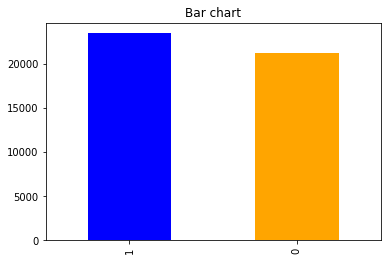

In [26]:
ax, fig = plt.subplots()
etiquetas = df['label'].value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Podemos concluir que el dataset está balanceado aunque las fake news ganan a las real news

* **Distribución de la longitud de los tweet en caracteres:**


Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma. 

Comenzamos creando las columnas que van a almacenar las longitud en caracteres y en tokens de los documentos del corpus:

In [27]:
df['length'] = df['title_text'].apply(lambda x: len(x))

In [28]:
df.head(2)

,title_text,label,subject,length
0,"As U.S. budget fight looms, Republicans flip t...",0,politicsNews,4724
1,U.S. military to accept transgender recruits o...,0,politicsNews,4142


En clase, se ha realizado el código de a continuación para poder visualizar mejor la distribucion de la longitud de las noticias en caracteres

Para la realizacion de este gráfico vamos a ver qué tipo de datos estamos trabajando ya que tendremos que pasar la variable label como int

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44685 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title_text  44685 non-null  object
 1   label       44685 non-null  object
 2   subject     44685 non-null  object
 3   length      44685 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [30]:
df['label']= df['label'].astype(int)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


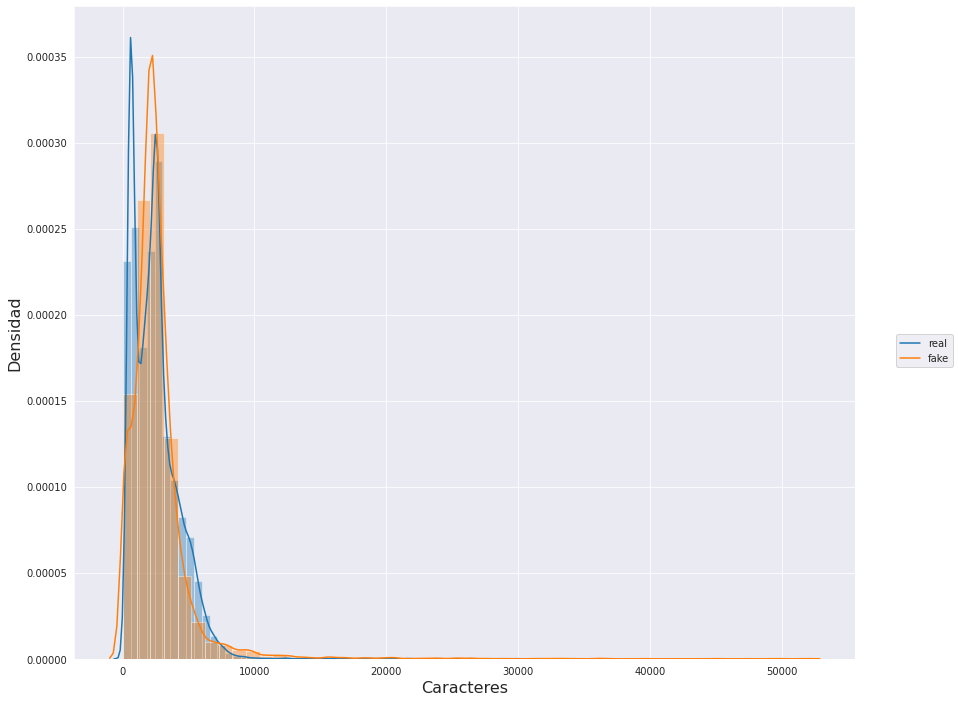

In [31]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(df[df.label==0].length, hist=True, label="real")
plt2 = sns.distplot(df[df.label==1].length, hist=True, label="fake")
fig.legend(labels=['real','fake'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

 Vemos que las distribuciones de longitud de los titulares y el texto llevan una distribucion similar,aunque la distribucion de las noticias falsas parecen tener outliers. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f33d859e370>,
 'caps': [<matplotlib.lines.Line2D at 0x7f33d859ea30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f33d85b8eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f33d85a5130>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f33d85a5430>],
 'means': []}

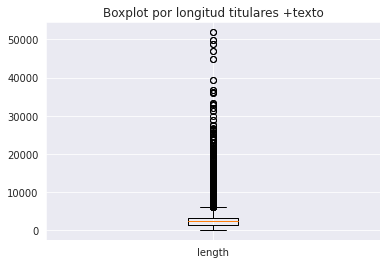

In [32]:
fig, ax = plt.subplots()
ax.set_title('Boxplot por longitud titulares +texto')
ax.boxplot(df['length'],labels=["length"])

In [33]:
# Calcular número de palabras por documento
df["nwords"] = df["title_text"].apply(lambda s: len(s.split(" ")))


In [34]:
# Calcular media de caracteres por palabra
df["avg_char_word"] = df["title_text"].apply(lambda s: len(s) / len(s.split(" ")))
df.head(2)

,title_text,label,subject,length,nwords,avg_char_word
0,"As U.S. budget fight looms, Republicans flip t...",0,politicsNews,4724,763,6.191350
1,U.S. military to accept transgender recruits o...,0,politicsNews,4142,634,6.533123


In [36]:
# Calcular número de palabras distintas
df["n_distint_word"] = df["title_text"].apply(lambda s: len(set(s.split(" "))))
df

,title_text,label,subject,length,nwords,avg_char_word,n_distint_word
0,"As U.S. budget fight looms, Republicans flip t...",0,politicsNews,4724,763,6.191350,427
1,U.S. military to accept transgender recruits o...,0,politicsNews,4142,634,6.533123,340
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0,politicsNews,2850,476,5.987395,260
3,FBI Russia probe helped by Australian diplomat...,0,politicsNews,2521,386,6.531088,239
4,Trump wants Postal Service to charge 'much mor...,0,politicsNews,5274,875,6.027429,455
...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1,Middle-east,3299,552,5.976449,316
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1,Middle-east,1766,313,5.642173,196
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1,Middle-east,25151,4357,5.772550,1701
23479,How to Blow $700 Million: Al Jazeera America F...,1,Middle-east,2753,488,5.641393,297


In [47]:
df["nwords"].describe(percentiles=[0.25])

count    44685.000000
mean       428.081235
std        362.211740
min          2.000000
25%        221.000000
50%        383.000000
max       8449.000000
Name: nwords, dtype: float64

In [46]:
#df[df["nwords"] < 25]["title_text"].tolist()[1]

In [41]:
Q1 = np.percentile(df['nwords'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['nwords'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [45]:

 
# Upper bound
upper = np.where(df['nwords'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['nwords'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True,axis = 0)
df.drop(lower[0], inplace = True,axis = 0)
 
print("New Shape: ", df.shape)

Old Shape:  (44685, 7)


KeyError: ignored